# CGM Data Quality Analysis Tutorial
## Using cgm-data-processor with XDrip+ Backups

This notebook demonstrates a practical workflow for processing Continuous Glucose Monitoring (CGM) data using the cgm-data-processor tool. We'll walk through loading data from an XDrip+ SQLite backup, performing quality assessments, and exporting the processed data in a standardized format suitable for further analysis.

### Overview

The cgm-data-processor tool simplifies the process of working with CGM data by handling common preprocessing tasks and standardizing the output format. This example focuses on three key aspects:

1. Data Loading: Extracting CGM measurements, carbohydrate records, and insulin data from an XDrip+ SQLite backup
2. Quality Assessment: Evaluating data completeness, identifying gaps, and assessing measurement reliability
3. Standardized Export: Saving the processed data in a consistent CSV format that facilitates further analysis

### Prerequisites

Before running this notebook, ensure you have:
- The cgm-data-processor package installed
- An XDrip+ SQLite backup file
- Basic familiarity with Python and pandas

### Expected Output

The processed datasets will include:
- Glucose measurements aligned to 5-minute intervals
- Values in both mg/dL and mmol/L units
- Validated carbohydrate and insulin records
- Quality metrics for each time period
- Clearly marked data gaps and interpolated values

### Data Quality Considerations

Throughout this tutorial, we'll examine several key quality metrics:
- Measurement frequency and consistency
- Gap duration and distribution

This quality assessment helps ensure that subsequent analyses are based on reliable data and that any limitations are well understood.

### Next Steps

After completing this tutorial, you'll have a standardized dataset ready for various analyses such as:
- Glucose variability assessment
- Meal response patterns
- Insulin sensitivity calculations
- Time-in-range analysis

Let's begin by importing the necessary libraries and setting up our environment.

In [1]:
import pandas as pd
import numpy as np
# Optional imports
from IPython.display import Image
import pprint

## Project Setup and Module Imports

This notebook relies on a modular codebase organized into three main components:

1. Preprocessing: Handles data loading from XDrip+ backups, cleaning operations, and timeline alignment
2. Analysis: Provides tools for assessing data quality, gap detection, and statistical analysis
3. Visualization: Creates informative dashboards and plots for quality assessment

The following code adds the project root to the Python path and imports the necessary functionality from each module. Each import is organized by its primary function to maintain clarity and facilitate future extensions of the codebase.

In [2]:
# Path modification used to allow Notebook access to src directory
import os
import sys
notebook_path = os.path.abspath('.')
project_root = os.path.join(notebook_path, '../../')
if project_root not in sys.path:
    sys.path.append(project_root)

# Preprocessing Module - Load, clean and align data
from src.preprocessing.loading import XDrip
from src.preprocessing.cleaning import clean_classify_insulin, clean_classify_carbs, clean_glucose
from src.preprocessing.alignment import align_diabetes_data

# Analysis Module - Check and display data quality
from src.analysis.gaps import analyse_glucose_gaps

# Visualisation Module - Format data for visual appeal in Jupyter
from src.visualisation.gap_dashboard import create_gap_dashboard

## Data Loading

Here we initialize our data processing pipeline by loading an XDrip+ SQLite backup file. The `XDrip` class provides a clean interface for accessing and processing the raw CGM data.

The SQLite backup file contains the complete dataset including glucose readings, insulin records, and carbohydrate entries. The `XDrip` class handles the low-level database interactions and provides structured access to this data.

Note: When using your own data, replace the `db_path` with the path to your XDrip+ SQLite backup file. XDrip+ backups can be generated from within the XDrip+ application under Settings > Data Source > Export Database.

In [3]:
# Path to your SQLite file
db_path = '../../data/export20240928-130349.sqlite'
data = XDrip(db_path) # Load db path into XDrip class - Class found in src directory

## Initial Data Extraction

In this step, we extract two primary datasets from the XDrip+ backup:

1. Glucose Measurements (`bg_df`): This dataset contains continuous glucose monitoring readings, typically recorded at 5-minute intervals. Each reading includes the glucose value and associated metadata such as the timestamp and reading quality indicators.

2. Treatment Records (`treatment_df`): This dataset encompasses both insulin administration and carbohydrate intake records. The timestamps in this dataset may be irregular as they correspond to specific events rather than continuous monitoring.

Both dataframes are automatically configured with their timestamps as indices, and dropping any rows with duplicate timestamps, facilitating temporal analysis and alignment in subsequent processing steps. The `XDrip` class handles the SQL queries and initial data structuring, ensuring consistent data types and timestamp handling across the extracted datasets.

Note: These raw dataframes will undergo further processing and quality assessment before being combined into our standardized format. This two-stage loading approach allows us to validate and clean each data type independently before integration.

In [4]:
bg_df = data.load_glucose_df() # Load glucose data into a pandas dataframe - Function found in src directory
treatment_df = data.load_treatment_df() # Load treatment data into a pandas dataframe - Function found in src directory

## Insulin Data Processing

The `clean_classify_insulin()` function processes the raw treatment records to create a structured insulin dataset. This critical step separates insulin records from other treatments and applies standardization rules specific to insulin data. 

There are two optional parameters than can be supplied to this function:
- bolus_limit - Number of units where insulin doses above this should be classified as basal, default = 8
- max_limit - Number of units where user would suggest it must be an error to be discarded, default = 15

The function handles several key aspects of insulin data processing:
- Extracts insulin-specific records from the treatment dataset
- Classifies insulin entries into basal and bolus categories - through meta-data or doseage
- Validates dosage values and units
- Standardizes timestamp formats
- Removes any duplicate or invalid entries
- Sets index to timestamp column

The resulting `insulin_df` provides a clean, validated dataset of insulin records, split by basal vs bolus and with a flag to see if the data was labeled by the user, that is ready to be integrated into our final standardized format.

In [5]:
insulin_df = clean_classify_insulin(treatment_df) # Function in source directory

## Carbohydrate Data Processing

After processing insulin records, we now clean and standardize the carbohydrate data using the `clean_classify_carbs()` function. This function implements specific validation rules to ensure data quality and consistency:

1. The function filters for meaningful carbohydrate entries by keeping only records with 1.0 grams or more, eliminating negligible or potentially erroneous entries.

2. It handles duplicate timestamps by keeping only the first entry for any given time, which prevents double-counting of meals while preserving the earliest recorded entry.

3. The resulting `carb_df` contains a simplified structure with just the essential carbohydrate quantities indexed by timestamp, making it ready for integration with our other standardized data streams.

This cleaned carbohydrate dataset will be crucial for analyzing meal-related glucose responses and understanding overall patterns in carbohydrate intake alongside glucose measurements.

In [6]:
carb_df = clean_classify_carbs(treatment_df) # Function in source directory

## Glucose Data Processing and Standardization

The `clean_glucose()` function performs comprehensive processing of raw CGM data to create a standardized, analysis-ready glucose dataset with consistent time intervals and validated measurements.

### Temporal Standardization
The function first standardizes the temporal aspects of the data by rounding timestamps to 5-minute intervals, which is the standard measurement frequency for most CGM systems. It then creates a complete timeline by generating a continuous 5-minute interval index spanning the entire monitoring period. This ensures we have a consistent temporal structure, even when raw data points are missing or irregularly spaced.

### Gap Handling and Data Quality
A key feature of the processing is its sophisticated handling of data gaps. The function identifies and flags missing data points, creating a 'missing' indicator that allows downstream analyses to distinguish between measured and interpolated values. For gaps up to 20 minutes (four 5-minute intervals), the function applies linear interpolation to estimate glucose values. This approach balances the need for continuous data with the importance of maintaining data integrity.

### Measurement Standardization
The function implements several measurement quality controls:
- Glucose values are constrained to a physiologically reasonable range of 39.64 to 360.36 mg/dL (2.2 to 20.0 mmol/L)
- Measurements are provided in both mg/dL and mmol/L units using the standard conversion factor of 0.0555
- Where multiple readings exist for a single 5-minute interval, they are averaged to provide a single representative value

The resulting dataset includes three essential columns:
1. Glucose measurements in mg/dL
2. Parallel measurements in mmol/L
3. Missing data flags to indicate interpolated values

This processed glucose dataset forms the backbone of our standardized CGM data structure, providing a reliable foundation for subsequent analysis while maintaining transparency about data quality and completeness.

In [7]:
glucose_df = clean_glucose(bg_df) # Function in source directory

## Data Alignment and Integration

The `align_diabetes_data()` function performs a critical step in our processing pipeline: combining our pre-processed glucose measurements (including interpolated values), carbohydrate records, and insulin data into a single, temporally aligned dataset with consistent 5-minute intervals.

### Input Data Characteristics
The function expects three pre-processed dataframes:
- Glucose data (`bg_df`) with measurements in both units (mg/dL and mmol/L) and a 'missing' flag indicating where values have been interpolated over gaps up to 20 minutes
- Carbohydrate records (`carb_df`) with validated gram quantities
- Insulin data (`insulin_df`) with classified basal and bolus doses

### Alignment Process
The function takes these independently processed dataframes and performs several key integration steps:

1. **Temporal Alignment**: All timestamps are rounded to 5-minute intervals to ensure consistent temporal binning across all data types, maintaining the integrity of our interpolated glucose values.

2. **Treatment Data Aggregation**:
  - Multiple insulin doses within the same 5-minute window are summed
  - Multiple carbohydrate entries within the same window are summed
  - Insulin entries maintain their classification (bolus/basal) and labeling

3. **Unified Timeline**: The function uses the glucose measurements' timeline (including interpolated values) as the master index, ensuring:
  - Complete coverage of the monitoring period
  - Consistent 5-minute intervals throughout
  - Preservation of gap indicators for transparency

### Output Structure
The resulting `aligned_df` provides a comprehensive view of diabetes management data with:
- Regular 5-minute interval timestamps
- Glucose values in both mg/dL and mmol/L units
- Missing data indicators showing where glucose values were interpolated
- Summed carbohydrate quantities
- Aggregated insulin doses (both basal and bolus)
- Boolean flags for labeled insulin entries

Missing treatment values (carbohydrates and insulin) are filled with zeros, while the glucose values and their interpolation status are preserved from the pre-processed glucose dataset. This maintains transparency about data quality while providing a complete timeline for analysis.

This aligned dataset serves as our standardized format, ready for various analyses including meal response patterns, insulin sensitivity calculations, and machine learning applications where understanding data completeness and interpolation is crucial.

In [8]:
aligned_df = align_diabetes_data(glucose_df, carb_df, insulin_df)

## Data Quality Analysis: Glucose Reading Gaps

After aligning and interpolating our data, we perform a comprehensive analysis of gaps in glucose readings using two specialized functions:

1. `analyse_glucose_gaps()`: Performs detailed analysis of missing data patterns
2. `create_gap_dashboard()`: Visualizes the gap analysis results in an interactive dashboard

### Gap Analysis Process
The analysis examines several key aspects of data completeness:

1. **Initial Data Quality**:
  - Identifies all missing glucose readings
  - Calculates the percentage of missing data before interpolation
  - Determines the total number of 5-minute intervals in the dataset

2. **Gap Characterization**:
  - Identifies continuous sequences of missing values
  - Measures gap durations in minutes
  - Records start and end times for each gap
  - Calculates gap statistics (mean, median, total duration)

3. **Post-Interpolation Assessment**:
  - Evaluates remaining gaps after 20-minute interpolation limit
  - Compares initial vs. remaining missing data percentage
  - Identifies largest continuous gaps

### Interactive Dashboard
The dashboard provides a comprehensive view of data quality through:

1. **Summary Metrics**:
  - Gauge displays for initial and remaining missing data percentages
  - Indicators for total gap counts before and after interpolation
  - Comprehensive statistics table with detailed metrics

2. **Visual Analysis**:
  - Bar chart of the top 10 largest gaps
  - Scatter plot showing distribution of all gaps
  - Interactive tooltips with detailed timing information

3. **Statistics Display**:
  - Total readings and missing values
  - Gap duration statistics (mean, median, quartiles)
  - Standard deviation of gap lengths
  - Maximum and minimum gap durations

This analysis provides crucial context for understanding data quality and helps identify periods where additional monitoring or different analysis approaches might be needed.

Enhanced Gaps Dashboard saved to img/gaps_dashboard.png


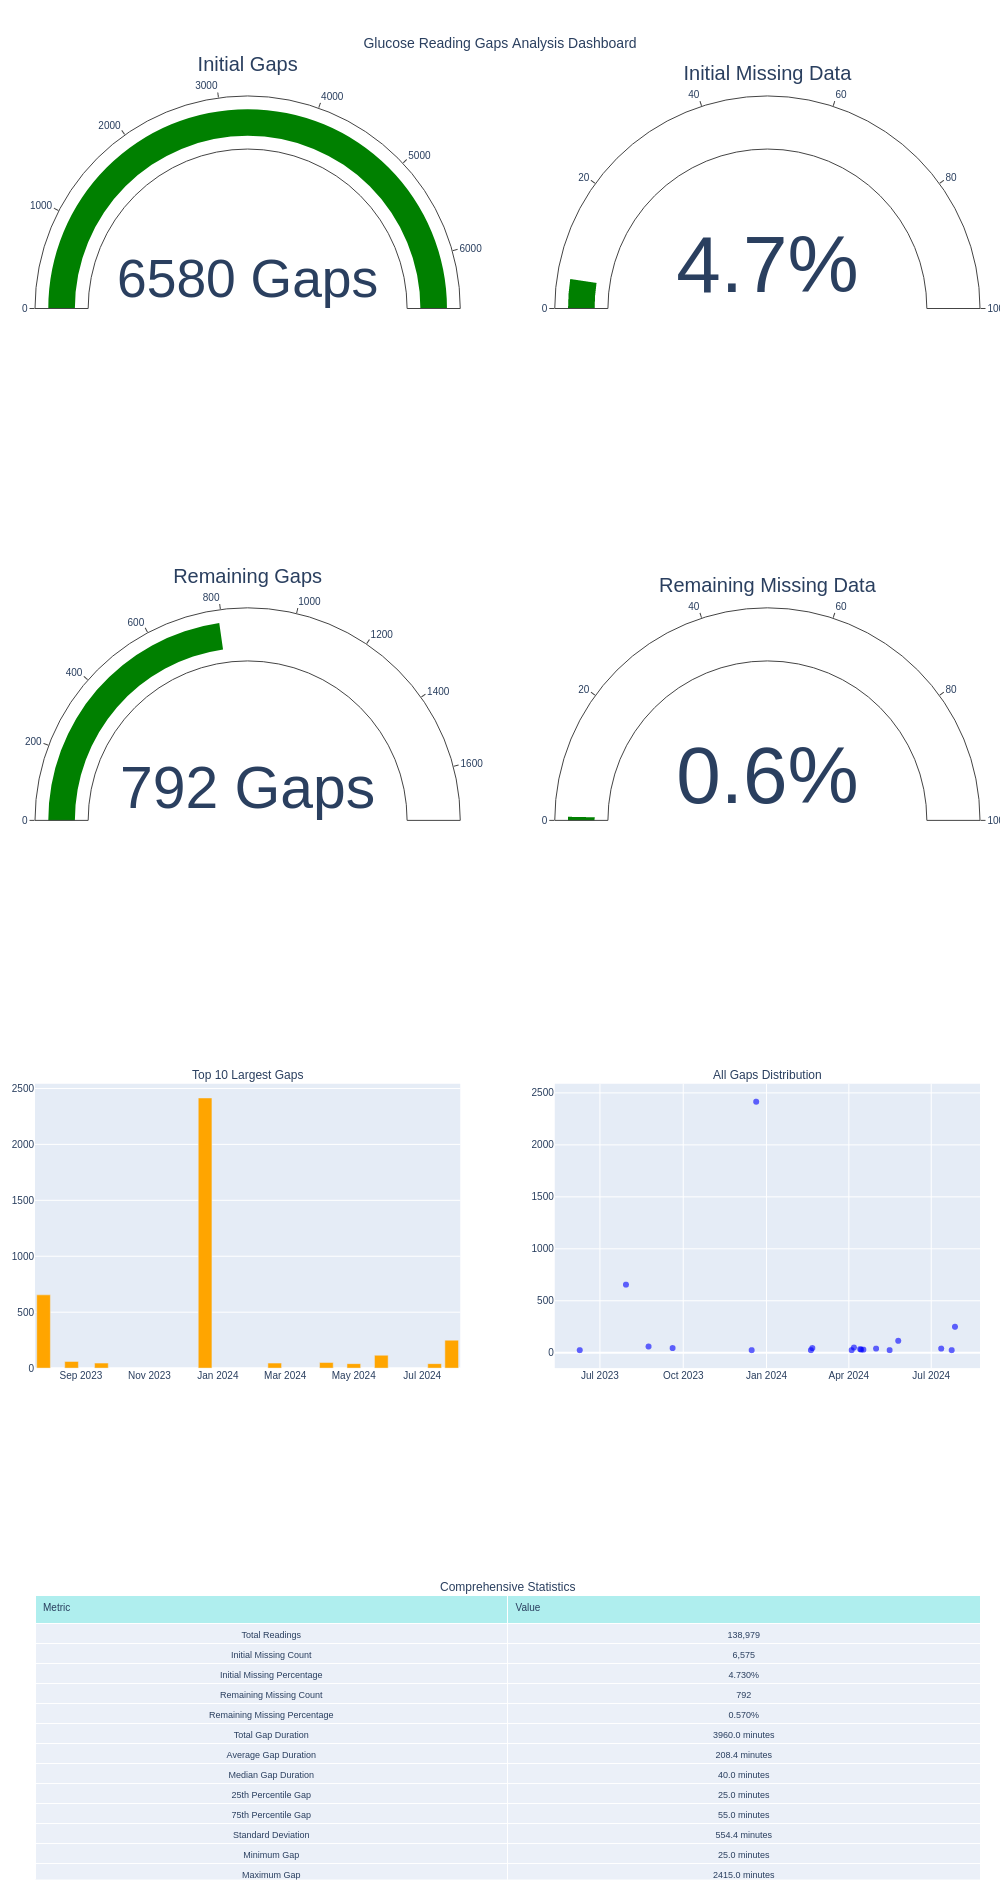

In [9]:
# Analyse missing glucose values
glucose_gap_analysis = analyse_glucose_gaps(aligned_df)

# Display analysis results
img_path = 'img/gaps_dashboard.png'
fig = create_gap_dashboard(glucose_gap_analysis, save_path=img_path)

# fig.show() # Display interactive plot

Image(filename=img_path) # Display solid PNG image of plot

## Data Export and Next Steps

We now export our processed datasets to CSV files for further analysis and reproducibility. Each file contains a specific aspect of the diabetes management data:

1. **complete.csv**: 
  - Our fully processed, temporally aligned dataset
  - Contains all measurements at regular 5-minute intervals
  - Includes glucose values, carbohydrates, insulin, and data quality indicators

2. **glucose_readings.csv**:
  - Clean glucose measurements in both mg/dL and mmol/L
  - Includes flags for interpolated values
  - All measurements aligned to 5-minute intervals

3. **carbs.csv**:
  - Validated carbohydrate intake records
  - Cleaned and filtered for meaningful entries (≥1g)

4. **insulin.csv**:
  - Processed insulin records
  - Separated into basal and bolus categories

These standardized CSV files provide a foundation for various analyses, such as:
- Meal response pattern analysis
- Insulin sensitivity calculations
- Time-in-range assessments
- Machine learning applications
- Statistical analysis of diabetes management patterns

The consistent format and documented processing steps ensure reproducibility and facilitate sharing with other analysis tools and platforms.

In [10]:
aligned_df.to_csv('../../data/complete.csv')
glucose_df.to_csv('../../data/glucose_readings.csv')
carb_df.to_csv('../../data/carbs.csv')
insulin_df.to_csv('../../data/insulin.csv')